In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as net
import lammps_logfile
from itertools import count
%matplotlib inline

In [2]:
def scale01(M):

    New_M = np.zeros((M.shape))
    MIN = np.min(M)
    MAX = np.max(M)
    for i in range(M.shape[0]):
            M_ = M[i]
            if (MAX == MIN):
                New_M[i] = 0.0 * M_
            else:
                New_M[i] = (M_ - MIN) / (MAX - MIN)

    return New_M

In [3]:
# Plot functions
from scipy import stats
from scipy.stats import gaussian_kde

def set_size(width, fraction=1):
    """ Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


def freedman_diaconis(data, returnas="width"):
    """
    Use Freedman Diaconis rule to compute optimal histogram bin width. 
    ``returnas`` can be one of "width" or "bins", indicating whether
    the bin width or number of bins should be returned respectively. 


    Parameters
    ----------
    data: np.ndarray
        One-dimensional array.

    returnas: {"width", "bins"}
        If "width", return the estimated width for each histogram bin. 
        If "bins", return the number of bins suggested by rule.
    """
    
    data = np.asarray(data, dtype=np.float_)
    IQR = stats.iqr(data, rng=(25, 75), scale=1.0, nan_policy="omit")
    if(IQR == 0 or np.isinf(data.max())):
        # int(freedman_diaconis(data[data!=0], returnas="bins")/(np.sum(data!= 0)/len(data)))
        NBRBINS = -1
        bw = -1
    else:
        N = data.size
        bw = (2 * IQR) / np.power(N, 1/3)
        datmin, datmax = data.min(), data.max()
        datrng = datmax - datmin
        NBRBINS = int((datrng / bw) + 1)
    return(NBRBINS, bw)

def get_hist(array,xname,yname):
    figsize=set_size(500.484)
    fig, axs = plt.subplots(1, 1, figsize=(8,8))
    NBR_BINS, bw = freedman_diaconis(data=array, returnas="bins")
    
    weights = 100*np.ones(len(array)) / len(array)
    
    if(NBR_BINS > 100):
        NBR_BINS = 100
    
    if(NBR_BINS <= 0):
        Prob_dist, bin_edges, _ = axs.hist(
            array, weights=weights, histtype='stepfilled',range=[-1,1]) 
    else:
        (Prob_dist, bin_edges) = histogram(array, bins=NBR_BINS, density=True)
#         Prob_dist, bin_edges, _ = axs.hist(array, bins=NBR_BINS, 
#                                            histtype='bar',density=True, 
#                                            fill=False, cumulative=False, 
#                                            log=False)
#     plt.clf()
#     plt.axvline(x=1, label='line at x = {}'.format(1), c='r', ls='--')
#     plt.xlabel(xname)
#     plt.ylabel(yname)
#     plt.legend()
#     plt.show()
    assert abs(np.dot(Prob_dist,np.diff(bin_edges))-1) < 1e-5
    
    bin_avgs = (bin_edges[:-1]+bin_edges[1:])/2
    y = Prob_dist[Prob_dist!=0]
    x = bin_avgs[Prob_dist!=0]
    return x, y 

In [4]:
from numpy import zeros, sqrt, where, pi, mean, arange, histogram, array

def pairCorrelationFunction_2D(x, y, S, rMax, dr):
    """Compute the two-dimensional pair correlation function, also known
    as the radial distribution function, for a set of circular particles
    contained in a square region of a plane.  This simple function finds
    reference particles such that a circle of radius rMax drawn around the
    particle will fit entirely within the square, eliminating the need to
    compensate for edge effects.  If no such particles exist, an error is
    returned. Try a smaller rMax...or write some code to handle edge effects! ;)
    Arguments:
        x               an array of x positions of centers of particles
        y               an array of y positions of centers of particles
        S               length of each side of the square region of the plane
        rMax            outer diameter of largest annulus
        dr              increment for increasing radius of annulus
    Returns a tuple: (g, radii, interior_indices)
        g(r)            a numpy array containing the correlation function g(r)
        radii           a numpy array containing the radii of the
                        annuli used to compute g(r)
        reference_indices   indices of reference particles
    """
    # Number of particles in ring/area of ring/number of reference particles/number density
    # area of ring = pi*(r_outer**2 - r_inner**2)

    # Find particles which are close enough to the box center that a circle of radius
    # rMax will not cross any edge of the box
    bools1 = x > rMax
    bools2 = x < (S - rMax)
    bools3 = y > rMax
    bools4 = y < (S - rMax)
    interior_indices, = where(bools1 * bools2 * bools3 * bools4)
    num_interior_particles = len(interior_indices)

    if num_interior_particles < 1:
        raise  RuntimeError ("No particles found for which a circle of radius rMax\
                will lie entirely within a square of side length S.  Decrease rMax\
                or increase the size of the square.")

    edges = arange(0., rMax + 1.1 * dr, dr)
    num_increments = len(edges) - 1
    g = zeros([num_interior_particles, num_increments])
    radii = zeros(num_increments)
    numberDensity = len(x) / S**2

    # Compute pairwise correlation for each interior particle
    for p in range(num_interior_particles):
        index = interior_indices[p]
        d = sqrt((x[index] - x)**2 + (y[index] - y)**2)
        d[index] = 2 * rMax

        (result, bins) = np.histogram(d, bins=edges, normed=False)
        g[p, :] = result/numberDensity

    # Average g(r) for all interior particles and compute radii
    g_average = zeros(num_increments)
    for i in range(num_increments):
        radii[i] = (edges[i] + edges[i+1]) / 2.
        rOuter = edges[i + 1]
        rInner = edges[i]
        g_average[i] = mean(g[:, i]) / (pi * (rOuter**2 - rInner**2))

    return (g_average, radii, interior_indices)

# Reading LAMMPS data Final status

In [55]:
def read_pairwise(STEP):

    file1 = open(dir_+'neigh.deform', 'r')
    lines = [line.rstrip() for line in file1] 

    for num, line in enumerate(lines, 0):
        if 'ITEM' in line:
            if 'ITEM: TIMESTEP' in line:
                curr_timestep = int(lines[num+1])
            if 'ITEM: NUMBER OF ENTRIES' in line:
                num_entries = int(lines[num+1])
                table = []
            if 'ITEM: ENTRIES' in line:
                if(curr_timestep != STEP):
                    continue
                x = lines[num+1:num+1+num_entries]
                for i in range(len(x)):
                    table.append(list(map(float, x[i].split(" "))))

                if(curr_timestep == STEP):
                    break

    print("read_pairwise:", curr_timestep, "STEP:", STEP, flush=True)
    pairwise = np.array(table.copy())

    return pairwise

def read_grain_data(STEP):
    file2 = open(dir_+'visualize.deform', 'r')
    lines = [line.rstrip() for line in file2]

    for num, line in enumerate(lines, 0):
        if 'ITEM' in line:
            if 'ITEM: TIMESTEP' in line:
                curr_timestep = int(lines[num+1])
            if 'ITEM: NUMBER OF ATOMS' in line:
                num_entries = int(lines[num+1])
                table = []
            if 'ITEM: ATOMS' in line:
                if(curr_timestep != STEP):
                    continue
                x = lines[num+1:num+1+num_entries]
                for i in range(len(x)):
                    table.append(list(map(float, x[i].split(" "))))

                if(curr_timestep == STEP):
                    break

    print("read_grain_data:", curr_timestep, "STEP:", STEP, flush=True)

    grains = np.array(table.copy()) 
    
    temp = grains[grains[:, 1] == 3]
    
    LX = np.max(temp[:,3])-np.min(temp[:,3])
    LY = np.min(temp[:,4]) - .5
    
    grains = grains[grains[:, 1] != 3]
    grains = grains[grains[:, 0].argsort()]

    return grains, LY, LX

In [148]:
dir_ = "../LAMMPS/uniaxial/results/Hooke_H-wall_V-periodic_Particle-indent/Hooke_H-wall_V-periodic_Particle-indent/"
# dir_ = dir_ + "0_0.0_0.0_1.0/"
# dir_ = dir_ + "1_0.01_0.0_1.0/"
# dir_ = dir_ + "2_0.1_0.0_1.0/"
# dir_ = dir_ + '3_0.0_0.01_1.0/'
# dir_ = dir_ + "6_0.01_0.04_1.0/"
# dir_ = dir_ + "7_0.01_0.8_1.0/"
# dir_ = dir_ + "9_0.1_0.04_1.0/"
# dir_ = dir_ + "10_0.1_0.8_1.0/"
# dir_ = dir_ + '1_0.0001_0_1.0/'
# dir_ = dir_ + "19_0.01_0_1.0/"
dir_ = dir_ + "28_0.1_0_1.0/"

# dir_ = "../LAMMPS/uniaxial/results/Hooke_deform_final/"
# dir_ = dir_ + "0.01_0_1.0/"

In [149]:
log2 = lammps_logfile.File(dir_+"log.deform")
STEP = int(log2.data_dict['Step'][-1])

grain0, L0y, _ = read_grain_data(0)
grains, Ly, Lx = read_grain_data(STEP)
pairwise0 = read_pairwise(0)
pairwise = read_pairwise(STEP)

read_grain_data: 0 STEP: 0
read_grain_data: 5100000 STEP: 5100000
read_pairwise: 0 STEP: 0
read_pairwise: 5100000 STEP: 5100000


# Pair correlation function

/home/ankit/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.


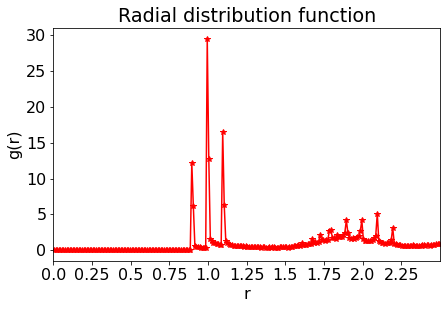

In [150]:
### Hexagonal circle packing ###
particle_radius = 1
domain_size = log2.data_dict['Lx'][-1]/particle_radius
rMax = 2.5
dr = .01
x = grains[:,3]/particle_radius
y = grains[:,4]/particle_radius

# Compute pair correlation
g_r, r, reference_indices = pairCorrelationFunction_2D(x, y, domain_size,
        rMax, dr)

# Visualize
fig, ax = plt.subplots(1, 1, figsize=set_size(500.484))
plt.rcParams['font.size'] = '16'
ax.plot(r, g_r, 'r*-')
ax.set_xlabel('r', fontsize=16)
ax.set_ylabel('g(r)')
# plt.grid()
ax.set_xlim( (0, rMax))
ax.set_xticks(np.arange(0, rMax, .25))
ax.set_xticklabels(np.arange(0, rMax, .25), fontsize=16)
# ax.set_ylim( (0, 1.05 * g_r.max()))
# ax.set_yticks(np.arange(0, 1.05 * g_r.max(), 5))
# ax.set_yticklabels(np.arange(0, 1.05 * g_r.max(), 5), fontsize=12)
ax.set_title('Radial distribution function')
plt.show()


# Particle Stress Data analsysis

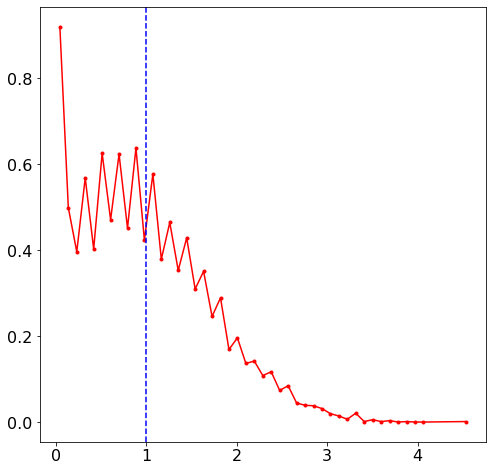

In [151]:
Criteria = np.around(grains[:,15],1)
# _ = get_hist(Criteria,"f/f","p(f)")

# Criteria_mean = np.mean(Criteria) 
# print( Criteria_mean, np.percentile(-Criteria, 60) )
Criteria = -Criteria/np.mean(-Criteria)
x, y = get_hist(Criteria,"Normalised Stress, $\hat{s}$","probability, p($\hat{s}$)")
c = ['r','b','g']
plt.plot(x,y, c[0]+'.-', label='')
plt.axvline(x=1, label='line at x = {}'.format(1), c='b', ls='--')

In [10]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x**2) + c

sigma_yy = grains[:,15]
# sigma_yy = sigma_yy/np.mean(sigma_yy)
# x, y = get_hist(sigma_yy)


# _ = plt.plot(x[x>0],y[x>0], '.')
# popt, pcov = curve_fit(func, x, y, bounds=(0, [3., 1., 0.5]))
# plt.plot(x, func(x, *popt), 'g--',
#          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

## Preprocessing Stress Information

In [11]:
# Calculate the linearity of network
# Checking correlation between principal strain edge angle

import math

contact_angle = {}
compressive_stress_angle  = {}
P1 = []
P2 = []

for grain in grains:
    gid = grain[0]
    S11 = grain[-6]
    S22 = grain[-5]
    S12 = grain[-3]
        
    # Angle of major principal stress with respect to x axis
#     theta = .5*math.atan(2*S12/(S11-S22))
#     print(theta, S12, (S11-S22), S11, S22)

#     # P2 is the most compressive stress (minor stress)
    p1 = 0.5*(S11+S22) + math.sqrt(.25*(S11-S22)**2+S12**2)
    p2 = 0.5*(S11+S22) - math.sqrt(.25*(S11-S22)**2+S12**2)
    P1.append(p1)
    P2.append(p2)
#     p = 0.5*(S11+S22) + 0.5*(S11-S22)*math.cos(2*theta) + S12*math.sin(2*theta)  
    
#     # Angle of minor principal stress (compressive stress)
#     if(abs(p1-p)<1e-10):
#         theta = np.pi/2+theta 
        
#     if(theta > math.pi/2):
#         theta = theta - math.pi
    
#     compressive_stress_angle[gid] = theta
#     if( gid not in contact_angle ):
#         contact_angle.setdefault(gid, [])
    
#     contact_angle[gid].append(S11)
#     contact_angle[gid].append(S22)
#     contact_angle[gid].append(S12)
#     contact_angle[gid].append(theta*180/math.pi)
P1 = np.array(P1)
P2 = np.array(P2)

In [ ]:
def funx1(x):
#     y = np.log(x) #np.log(x-np.min(x)+.0001)
    y = x
    return y

def funx2(x):
#     y = np.log(x) #np.log(x-np.min(x)+.0001)
    y = x**2
    return y

def Sigmayy_fit(x,y):
#     X1 = x[x<1]
#     LY1 = np.log(y[x<1])
#     fit1 = np.polyfit(funx1(X1), LY1, 1)
#     p1 = np.poly1d(fit1)

    # _ = plt.plot(X1, LY1, '.')
#     xp1 = np.linspace(np.min(X1), np.max(X1), 100)
#     _ = plt.plot(np.log(xp1), p1(funx1(xp1)),label=str(round(fit1[1],3)))

    X2 = x[x>=1]
    LY2 = np.log(y[x>=1])
    fit2 = np.polyfit(funx2(X2), LY2, 1)
    Lp2 = np.poly1d(fit2)

    # _ = plt.plot(X2, LY2, '.')
    xp2 = np.linspace(np.min(X2), np.max(X2), 100)
    _ = plt.plot(xp2, np.exp(Lp2(funx2(xp2))),label=str(round(fit2[1],3)))

#     LY = np.append(LY1,LY2, axis=0)
    LY = LY2
    X = X2
#     X = x
    _ = plt.plot(X, np.exp(LY), '.')

    plt.legend()
    plt.show()

In [ ]:
# Sigmayy
sigma_yy = grains[:,15]
sigma_yy = sigma_yy/np.mean(sigma_yy)

x, y = get_hist(sigma_yy[sigma_yy>1])
plt.show()

_ = plt.plot(x[x>0],y[x>0], '.')
plt.show()
Sigmayy_fit(x,y)

# y1 = plt.hist(sigma_yy, bins=100, histtype='step',density=True, fill=False, cumulative=False, log=False)
# plt.cla()
# bins1 = y1[1][1:]
# plt.plot(bins1,y1[0])
# plt.scatter(bins1,y1[0])
# plt.yscale('log')
# plt.xscale('log')

# plt.show()

# np.sort(np.unique(grains[:,15])) , np.percentile(Grain[:,15],60)

# Characterizing Force chains Using Contact Force

In [ ]:
Grain = grains
Grain[:, 9:] = grains[:, 9:]
Pairwise = pairwise
fx = pairwise[:, 5]
fy = pairwise[:, 6]
fn = np.sqrt(fx**2 + fy**2)
fN1 = fn / np.mean(fn)

Force_network = net.Graph()
nx, ny = Grain.shape
for node, x, y in zip(Grain[:, 0], Grain[:, 3], Grain[:, 4]):
    Force_network.add_node(node, pos=(x, y))

DIST = []
F = []
nx, ny = Pairwise.shape
for i in range(nx):
    id1 = int(Pairwise[i, 1]) - 1
    id2 = int(Pairwise[i, 2]) - 1
    dist = np.sqrt((Grain[id1, 3] - Grain[id2, 3])**2 +
                   (Grain[id1, 4] - Grain[id2, 4])**2)
    if (dist <= 5.0 and fN1[i] > np.mean(fN1)):
#     if(dist<=5.0 and fN1[i] > 1):
#     if(dist<=5.0):
        Force_network.add_edge(id1 + 1, id2 + 1, weight=fN1[i] / 10)

edges = Force_network.edges()
weights = [Force_network[u][v]['weight'] for u, v in edges]
pos = net.get_node_attributes(Force_network, 'pos')

# if (len(weights)):
#     vmin = min(weights)
#     vmax = max(weights)
#     if (vmax != vmin):
#         V = ((np.array(weights) - vmin) / (vmax - vmin))+1
#         V = np.log(V)

new_cmap = plt.get_cmap('jet')

# nodes = draw_networkx_nodes(Force_network, pos,node_size=0,node_color='none')
# nodes.set_edgecolor('black')

net.draw(Force_network,pos,edge_color='black',node_size=0,node_color='blue',edge_cmap=new_cmap)
# net.draw(Force_network,
#          pos,
#          edge_color='black',
#          width=V,
#          node_size=0,
#          node_color='none',
#          edge_cmap=new_cmap)
# plt.savefig("check.eps",format='eps',dpi=1000)

In [ ]:
# degrees = [val for (node, val) in Granular_network.degree()]
# degrees
Force_network.number_of_edges()

pos=net.get_node_attributes(Force_network,'pos')
net.draw(Force_network,pos,node_size=2)

Force_network.number_of_edges()/Force_network.number_of_nodes()

# Total Coordination number of force network,
mean_Degree = np.mean([val for (node, val) in Force_network.degree])
Coordination_number = 2*Force_network.number_of_edges()/Force_network.number_of_nodes()
print(mean_Degree, Coordination_number)
# Since for frictionless particles it is > 2d, it is stable 

np.unique([val for (node, val) in Force_network.degree])

# Characterizing Force chains Using Stress

In [64]:
def plot_force_chains(Grain, Criteria):
    par_type = Grain[:,1]
    x = Grain[:,3]
    y = Grain[:,4]
    R = Grain[:,2]
    #h = 1*(Criteria > 1)
    h = np.array([i if i > 1 else 0 for i in Criteria])
    s = scale01(h)
    colors = [matplotlib.cm.gray_r(color) for color in s]  
    
    f, ax1 = plt.subplots(1,1,figsize=(15,15))
    for xi, yi, r, color, t, lh in zip(x, y, R, colors, par_type, h):
        if(lh):
            circle = plt.Circle((xi,yi), r, color=color)  
            ax1.add_patch(circle)

    ax1.set_aspect('equal')
    ax1.set_xlim(min(x)-.5, max(x)+.5)
    ax1.set_ylim(min(y)-.5, max(y)+.5)
    plt.axis('off')
#     sc = ax1.scatter(x, y,c=h, s=20);
    sc = ax1.scatter(x, 
                     y, 
                     s=0, 
                     c=s, 
                     cmap='gray_r',
                     vmin = min(s[s!=0]),
                     vmax = max(s),
                     facecolors='none')

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(sc,cax=cax)
    cbar.set_label('C', rotation=270, labelpad=10)
    cbar.ax.tick_params(labelsize=25) 
    plt.show()

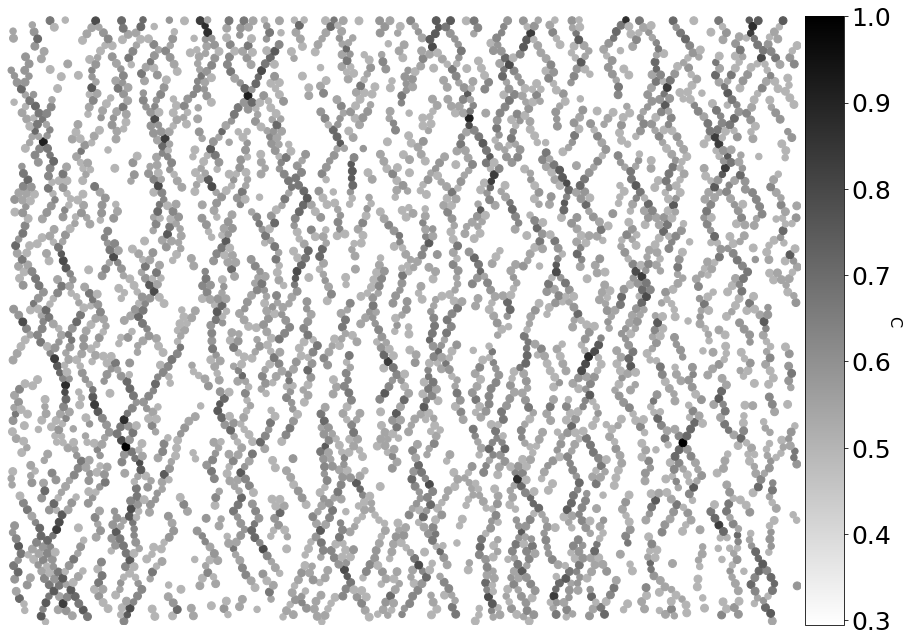

In [152]:
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

Grain = grains
Grain0 = grain0
index = 15
# Criteria = Grain[:,index]-Grain0[:,index]
# Criteria = Criteria/np.percentile(Criteria,60)
# Criteria = Grain[:,index]/np.mean(Grain[:,index])
Criteria = -np.around(Grain[:,index])/np.percentile(-np.around(Grain[:,index]),60)
# Criteria = -np.around(Grain[:,index])/np.mean(-np.around(Grain[:,index]))
# Criteria = -P2/np.percentile(-P2,60)


# I = 1*Grain[:,index]
# positive_index = I > 0
# I[positive_index] = 0
# II = abs(I)
# Criteria = -Grain[:,index]/np.percentile(-Grain[I<0,index],60)
# Criteria = II/np.percentile(II,60)

plot_force_chains(Grain, Criteria)

## Converting Force chains to Network

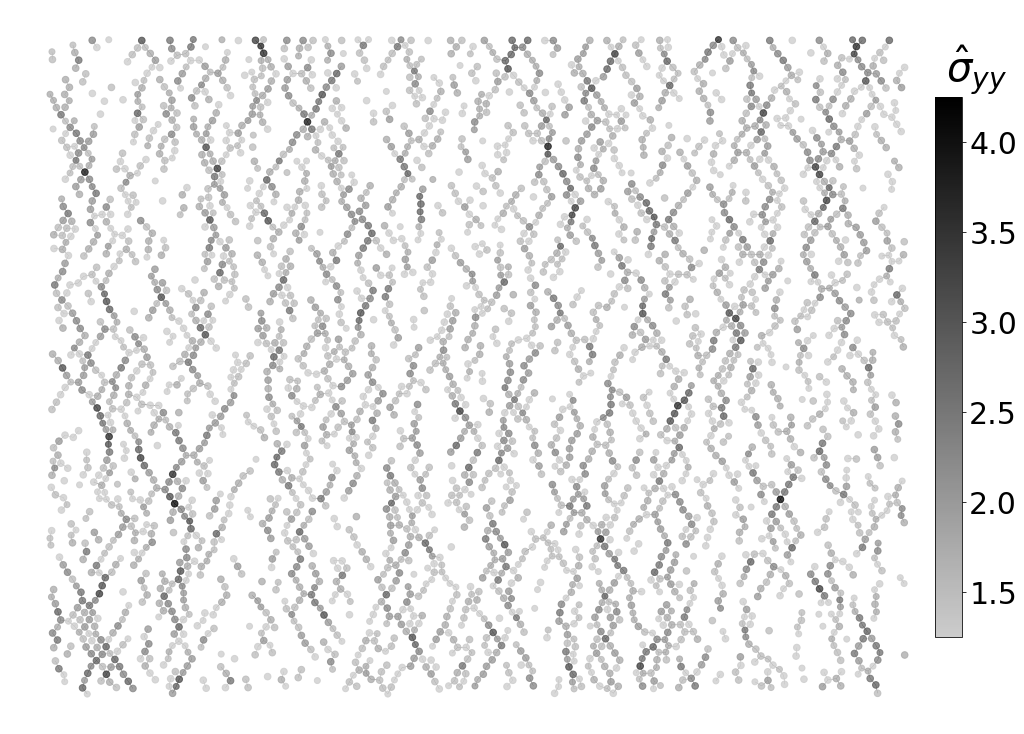

In [154]:
min_val, max_val = 0.2,1
n = 10
orig_cmap = plt.cm.gray_r
colors = orig_cmap(np.linspace(min_val, max_val, n))
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

def plot_force_chains_network(G):

    Ly = log2.data_dict['Ly'][-1]
    Lx = log2.data_dict['Lx'][-1]
    fig, ax1 = plt.subplots(1, 1, figsize=(10*Ly/Lx, 10))
    edges = G.edges()
    e_weight = [G[u][v]['weight']*1 for u, v in edges]
    pos = net.get_node_attributes(G, 'pos')

    weights = set(net.get_node_attributes(G, 'weight').values())
    mapping = dict(zip(sorted(weights), count()))
    nodes = G.nodes
    colors = [mapping[G.nodes[n]['weight']] for n in nodes]  
    size = [G.nodes[n]['size']*80 for n in nodes]
    net.draw(G, pos, 
             edge_color='black',
             node_size = size,
             node_color=colors, 
             cmap=mycmap,
             width = e_weight,
             alpha=.750)
    
    vmin = min(weights)
    vmax = max(weights)
    ax1.set_aspect('equal')
    sm = plt.cm.ScalarMappable(
        cmap=mycmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar=plt.colorbar(sm, shrink=0.75, pad=-0.01)
    cbar.set_label(r'$\hat{\sigma}_{yy}$',labelpad=-40, y=1.1, rotation=0,size=40)
    cbar.ax.tick_params(labelsize=30)
#     fig.tight_layout()
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.savefig('Direct.png',bbox_inches='tight')
    
plot_force_chains_network(Force_chains)

In [153]:
Force_chains=net.Graph()

Pairwise = pairwise

fx = Pairwise[:, 5]
fy = Pairwise[:, 6]
fn = np.sqrt(fx**2 + fy**2)
fN1 = fn / np.mean(fn)

nx,ny = Grain.shape
for node, x, y, h, s in zip(Grain[:,0],Grain[:,3],Grain[:,4], Criteria, Grain[:,2]):
    if(h > 1):
        Force_chains.add_node(node, pos=(x,y), weight=h, size=s )

nx,ny = Pairwise.shape
for i in range(nx):
    id1 = int(Pairwise[i,1])-1
    id2 = int(Pairwise[i,2])-1
    dist = np.sqrt((Grain[id1, 3] - Grain[id2, 3])**2 +
                   (Grain[id1, 4] - Grain[id2, 4])**2)
    if (dist <= 5.0 and Force_chains.has_node(id1+1) and Force_chains.has_node(id2+1)):
        Force_chains.add_edge(id1+1, id2+1,weight=fN1[i]/10)

# edges = Force_chains.edges()
# weights = [Force_chains[u][v]['weight'] for u, v in edges]
# pos = net.get_node_attributes(Force_chains,'pos')
# new_cmap = plt.get_cmap('jet')
# # net.draw(Force_chains,pos,edge_color='black',node_size=1,node_color='blue',edge_cmap=new_cmap)
# net.draw(Force_chains,pos,edge_color=weights,node_size=1,node_color='blue',edge_cmap=new_cmap)
# vmin = min(weights)
# vmax = max(weights)
# sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
# sm._A = []
# plt.colorbar(sm,shrink=0.9)
# plt.show()

# Postprocessing Force chains

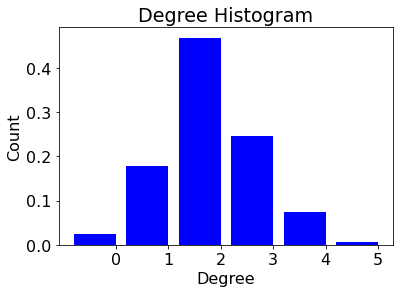

In [18]:
# Degree histogram
import collections
import networkx as nx

G = Force_chains
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt/np.sum(cnt), width=0.80, color="b")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
# plt.axes([0.4, 0.4, 0.5, 0.5])
# Gcc = G.subgraph(sorted(net.connected_components(G), key=len, reverse=True)[0])
# pos = nx.spring_layout(G)
# plt.axis("off")
# nx.draw_networkx_nodes(G, pos, node_size=20)
# nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.show()


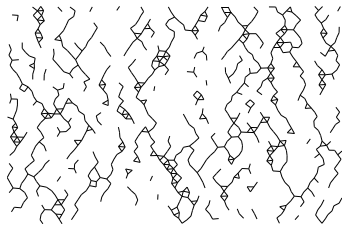

In [19]:
G = net.Graph.copy(Force_chains)
for node, degree in list(Force_chains.degree):
    if(degree == 0):
        G.remove_node(node)

pos = net.get_node_attributes(G,'pos')
fig = plt.figure()
axes = fig.add_subplot(1,1,1)
net.draw(G,pos,node_size=0,node_color='blue', ax= axes)
# axes.axis('on')
# This should be called after all axes have been added
plt.margins(0)
# axes.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
# plt.show()

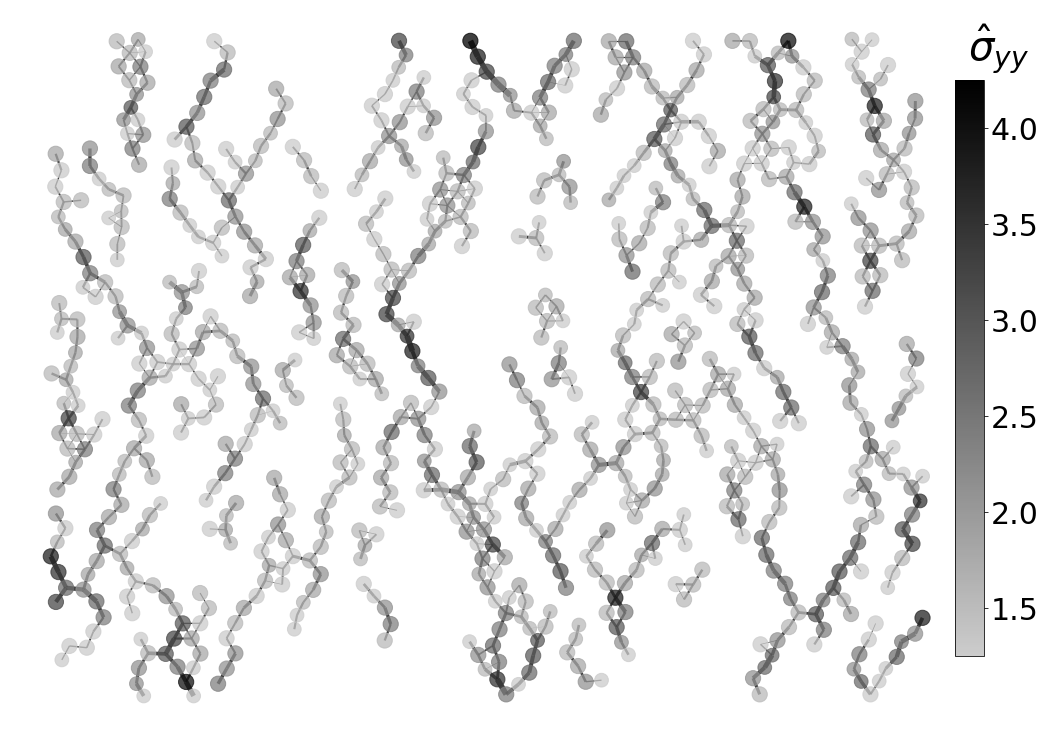

In [115]:
from matplotlib.pyplot import cm
G1 = net.Graph.copy(Force_chains)
sG = [G1.subgraph(c) for c in net.connected_components(G1)]
n = len(sG)

color = cm.rainbow(np.linspace(0, 1, n))
for index, sg in enumerate(sG):  #there's probably a more elegant approach using zip
#     net.draw(sg, 
#              pos = pos,
#              node_size=1,
#              edge_color = color[index]
#             )
    e = list(sg.nodes)
    if(len(e) <=3):
        G1.remove_nodes_from(e)

# edges = G1.edges()
# weights = [G1[u][v]['weight'] for u, v in edges]
# pos = net.get_node_attributes(G1,'pos')
# new_cmap = plt.get_cmap('jet')
# # net.draw(Force_chains,pos,edge_color='black',node_size=1,node_color='blue',edge_cmap=new_cmap)
# net.draw(G1,pos,edge_color=weights,node_size=1,node_color='blue',edge_cmap=new_cmap)
# vmin = min(weights)
# vmax = max(weights)
# sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
# sm._A = []
# plt.colorbar(sm,shrink=0.9)
# plt.show()
# net.draw(G1, 
#          pos = pos,
#          edge_color='black',
#          node_size=0,
#          node_color='blue'
#         )

plot_force_chains_network(G1)

In [ ]:
# Plot Indpendent connected components
from matplotlib.pyplot import cm
sG = [G1.subgraph(c) for c in net.connected_components(G1)]
n = len(sG)
pos = net.get_node_attributes(G1,'pos')
color = cm.rainbow(np.linspace(0, 1, n))
for index, sg in enumerate(sG):  #there's probably a more elegant approach using zip
    net.draw(sg, 
             pos = pos,
             node_size=0,
             edge_color = color[index]
            )

In [ ]:
# Community detection algorithm
from networkx.algorithms.community import greedy_modularity_communities
import networkx.algorithms.community as nx_comm


# best_res = 0
# max_mod = -1
# min_clust = 10000
# mod_L = []
# clu_L = []
# for resolution in np.linspace(0,3,1000):
#     G3 = net.Graph.copy(G1)
#     m = G3.number_of_edges()
#     for (u, v, d) in G3.edges(data=True):
#         G3[u][v]['weight'] = G3[u][v]['weight'] + (G3.degree[u]*G3.degree[v])/(2*m) - resolution*1

#     L_C = greedy_modularity_communities(G3, 
#                                         weight='weight')
    
#     mod = nx_comm.modularity(G3, L_C, weight='weight')
#     clust = len(L_C)
#     clu_L.append(clust)
#     mod_L.append(mod)
#     if(clust < min_clust):
#         min_clust = clust
#         best_res = resolution
        
# ---------------------------------------------------------------------------------
best_res = .15
G3 = net.Graph.copy(G1)
m = G3.number_of_edges()
for (u, v, d) in G3.edges(data=True):
    G3[u][v]['weight'] = G3[u][v]['weight'] + (G3.degree[u]*G3.degree[v])/(2*m) - best_res*1

L_C = greedy_modularity_communities(G3, 
                                    weight='weight')

mod = nx_comm.modularity(G3, L_C, weight='weight')

print(best_res, mod, len(L_C))
net.set_node_attributes(G3, 1, 'community')
for index, comm in enumerate(L_C):
    for node in comm:
        G3.nodes[node]['community'] = index

groups = set(net.get_node_attributes(G3,'community').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G3.nodes
colors = [mapping[G3.nodes[n]['community']] for n in nodes]
net.draw(G3,pos,edge_color='black',node_size=2,node_color=colors, cmap=plt.cm.hot)

In [ ]:
sG_L = []
for index, comm in enumerate(L_C):
    sG = net.Graph.copy(G3)
    for node in G3:
        if(sG.nodes[node]['community'] != index):
            sG.remove_node(node)
    sG_L.append(net.Graph.copy(sG))
    
n = len(sG_L)
color = cm.rainbow(np.linspace(0, 1, n))
for index, sg in enumerate(sG_L):  #there's probably a more elegant approach using zip
    pos = net.get_node_attributes(sg,'pos')
    net.draw(sg, 
             pos = pos,
             node_size=0,
             edge_color = color[index]
            )


In [ ]:
for sG in sG_L:
    max_distance = 0
    for u in sG.nodes:
        for v in sG.nodes:
            dist = abs(sG.nodes[u]['pos'][1]-sG.nodes[v]['pos'][1])
            if(dist > max_distance):
                max_distance = dist
    print(max_distance)

In [ ]:
chains = net.algorithms.chains.chain_decomposition(G3)
chain_list = list(chains)
n = len(chain_list)

color = cm.rainbow(np.linspace(0, 1, n))

Graph=net.Graph()
for index, chain in enumerate(chain_list):
    for edge in chain:
        Graph.add_edge(edge[0],edge[1],weight=index)
    
pos = net.get_node_attributes(G3,'pos')
edges = Graph.edges()
weights = [Graph[u][v]['weight'] for u, v in edges]
net.draw(Graph, 
         pos = pos,
         node_size=0,
         edge_color = 'black'
        )
plt.show()
net.draw(G3, 
         pos = pos,
         node_size=0,
         edge_color = 'black'
        )

In [ ]:
chains = net.algorithms.chains.chain_decomposition(G3)
chain_list = list(net.dfs_edges(G3))
n = len(chain_list)

color = cm.rainbow(np.linspace(0, 1, n))

Graph=net.Graph()
for index, edge in enumerate(chain_list):
    Graph.add_edge(edge[0],edge[1],weight=1)
    
pos = net.get_node_attributes(G3,'pos')
edges = Graph.edges()
weights = [Graph[u][v]['weight'] for u, v in edges]
net.draw(Graph, 
         pos = pos,
         node_size=0,
         edge_color = 'black'
        )
plt.show()


# Force chains Network Properties

In [ ]:
density = net.degree_histogram(G3)
print(density)
# plt.bar(range(7), density/np.sum(density), align='edge', width=1) ; plt.show()
# plt.show()

number_of_triangles = sum(net.triangles(G).values()) / 3
print(number_of_triangles)

Traingle_G = net.Graph.copy(G1)
triangles = net.triangles(Traingle_G)
for node in triangles:
    if(triangles[node] == 0):
        Traingle_G.remove_node(node)
net.draw(Traingle_G,pos,node_size=0,node_color='blue')
# plt.show()

In [ ]:
net.number_connected_components(Traingle_G)
# print(list(net.connected_components(G)))

In [ ]:
def isclose(a, b, rel_tol=1e-09, abs_tol=1e-13):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

sum_ = 0
for i in net.spectrum.laplacian_spectrum(Traingle_G):
    sum_+=isclose(i,0)*1
sum_

# Visualize Force chains

# Rough

In [ ]:
# Get Complete contact graph with forces


In [ ]:
# dict_ = net.all_pairs_node_connectivity(Force_network)
# net.algorithms.connectivity.connectivity.local_node_connectivity(Force_network, 13.0,14.0)

In [ ]:
# for node in dict_:
#     print(node, ":", dict_[node])

In [ ]:
# cliques = net.number_of_cliques(G)
# for node in cliques:
#     if(cliques[node] == 3):
#         G.remove_node(node)
# net.draw(G,pos,node_size=40,node_color='blue')

In [ ]:
height = np.percentile(np.array(list(pos.values()))[:,1],90)
posG = net.get_node_attributes(G1,'pos')
for node in posG:
    if(posG[node][1] >= height):
        tree = net.dfs_tree(G1, node)
        net.draw(net.DiGraph.to_undirected(tree), posG, node_size=0,node_color='blue')
#         plt.show()
#         plt.hist(net.spectrum.laplacian_spectrum(net.DiGraph.to_undirected(tree)))
#         plt.show()
plt.show()

In [ ]:
G = net.Graph.copy(Force_chains)
G.remove_edges_from(list(G.edges))
Bridge = list(net.bridges(Force_chains))
for u,v in Bridge:
    G.add_edge(u,v, weight=1)
net.draw(G,pos,node_size=2,node_color='blue')

In [ ]:
color = net.greedy_color(G, strategy="largest_first")
color_map = []
for node in G:
    color_map.append(color[node])
net.draw(G,pos,node_size=20,node_color=color_map,cmap=plt.cm.binary_r)

In [ ]:
# # for index, sg in enumerate(sG):
# #     a = net.percolation_centrality(sg, weight="weight")
# #     net.draw(sg,pos=pos, node_size=1)

# RAG = net.Graph()
# RA = net.resource_allocation_index(G1)
# for u, v, p in RA:
# #     print(f"({u}, {v}) -> {p:.8fvmin
#     if(p > .25):
#         RAG.add_edge(u, v,weight=p)

# # pos1 = net.get_node_attributes(RAG,'pos')
# new_cmap = plt.get_cmap('jet')
# edges = RAG.edges()
# weights = [RAG[u][v]['weight'] for u,v in edges]
# net.draw(RAG,pos,
#          edge_color=weights,
#          node_size=0,
#          width=1,
#          node_color='blue',
#          edge_cmap=new_cmap)
# vmin = min(weights)
# vmax = max(weights)
# sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
# sm._A = []
# plt.colorbar(sm,shrink=0.9)
# plt.show()


In [ ]:
# edges = G1.edges()
# weights = [G1[u][v]['weight'] for u, v in edges]
# pos = net.get_node_attributes(G1,'pos')
# new_cmap = plt.get_cmap('jet')
# # net.draw(Force_chains,pos,edge_color='black',node_size=1,node_color='blue',edge_cmap=new_cmap)
# net.set_node_attributes(G1, 1, 'percolation')
# percolation_cent_dict = net.percolation_centrality(G1, weight='weight', attribute='percolation')
# net.set_node_attributes(G1, percolation_cent_dict, 'percolation')


# from itertools import count
# groups = set(net.get_node_attributes(G1,'percolation').values())
# mapping = dict(zip(sorted(groups),count()))
# nodes = G1.nodes
# colors = [mapping[G1.nodes[n]['percolation']] for n in nodes]

# net.draw(G1,pos,edge_color='black',node_size=20,node_color=colors, cmap=plt.cm.hot_r)
# vmin = min(percolation_cent_dict.values())
# vmax = max(percolation_cent_dict.values())
# sm = plt.cm.ScalarMappable(cmap=plt.cm.hot_r, norm=plt.Normalize(vmin = vmin, vmax=vmax))
# sm._A = []
# plt.colorbar(sm,shrink=0.9)
# plt.show()

## InterParticle Force Analysis

In [ ]:
def funx1(x):
    y = np.log(x)
    return y

def funx2(x):
    y = np.log(x)
    return y

def force_network_fit(x,y):
    X1 = x[x<1]
    LY1 = np.log(y[x<1])
    fit1 = np.polyfit(funx1(X1), LY1, 1)
    p1 = np.poly1d(fit1)

    # _ = plt.plot(X1, LY1, '.')
    xp1 = np.linspace(np.min(X1), np.max(X1), 100)
    _ = plt.plot(np.log(xp1), p1(funx1(xp1)),label=str(round(fit1[1],3)))

    X2 = x[x>=1]
    LY2 = np.log(y[x>=1])
    fit2 = np.polyfit(funx2(X2), LY2, 1)
    p2 = np.poly1d(fit2)

    # _ = plt.plot(X2, LY2, '.')
    xp2 = np.linspace(np.min(X2), np.max(X2), 100)
    _ = plt.plot(np.log(xp2), p2(funx2(xp2)),label=str(round(fit2[1],3)))

#     LY = np.append(Y1,Y2)
#     X = x
#     _ = plt.plot(X, LY, '.')

    plt.legend()
    plt.show()

In [ ]:
fx = pairwise[:,5]
fy = pairwise[:,6]
fn = np.sqrt(fx**2+fy**2)
fN1 = fn/np.mean(fn)

x, y = get_hist(fN1)
plt.plot(x,y,'.')
plt.show()

# plt.plot(np.log(x),np.log(y),'.')
# force_network_fit(x,y)

In [ ]:
# theta = fx/fn

for grain in Grain:
    gid = grain[0]    
    contact_angle[gid].append(Force_network.degree[gid])

for edge in edges:
    x1,y1 = pos[edge[0]]
    x2,y2 = pos[edge[1]]
    deltax = x2-x1
    deltay = y2-y1
    theta = math.atan(deltay/deltax)*180/math.pi

    contact_angle[edge[0]].append(theta)  # wrt to grain(x1,y1)
    contact_angle[edge[1]].append(theta)  # wrt to grain(x2,y2)

In [ ]:
def generate_hex_circle_packing(a, width):
    """Generate a domain of a given width filled with hexagonally packed
    circles.  The height will be determined so that the vertical 
    boundary condition is periodic.
    Arguments:
    a       particle radius
    width   domain width, in terms of particle radius
    Returns:
    x_list  list of x coordinates
    y_list  list of y coordinates
    x_size  width of domain (equal to argument width)
    y_size  height of domain
    """
    numParticles = 0

    x_list = []
    y_list = []
    y = a
    x = a
    rowNumber = 0
    # Create a row
    while y <= width*1.01:
        # Create circles in a row
        while x < width:
            x_list.append(x)
            x = x + 2*a
            y_list.append(y)
            numParticles = numParticles + 1
        y = y + a*sqrt(3.)
        rowNumber = rowNumber + 1
        if rowNumber%2 == 0:
            x = a
        else:
            x = 0
    x_size = width
    y_size = rowNumber*a*sqrt(3)

    return array(x_list), array(y_list), x_size, y_size

def plot_adsorbed_circles(adsorbed_x, adsorbed_y, radius, width, reference_indices=[]):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    # Plot each run
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for p in range(len(adsorbed_x)):
        if len(np.where(reference_indices == p)[0]) > 0:
            ax.add_patch(Circle((adsorbed_x[p], adsorbed_y[p]), radius, 
                edgecolor='black', facecolor='black'))
        else:
            ax.add_patch(Circle((adsorbed_x[p], adsorbed_y[p]), radius,
                edgecolor='black', facecolor='white'))

    ax.set_aspect(1.0)
    plt.axhline(y=0, color='k')
    plt.axhline(y=width, color='k')
    plt.axvline(x=0, color='k')
    plt.axvline(x=width, color='k')
    plt.axis([-0.1*width, width*1.1, -0.1*width, width*1.1])
    plt.xlabel("non-dimensional x")
    plt.ylabel("non-dimensional y")

    return ax